In [12]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [13]:
!pip install pytorch-metric-learning

In [14]:
import torch
import torch.optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from tqdm import tqdm
from pytorch_metric_learning import miners, losses
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   # use GPU if available

## ViT

**[TO DO]** First let's implement the patchification process

In [15]:
class Patchify(nn.Module):
    # carries out patchification and embedding by applying same linear projection to all patches
    def __init__(self, img_size, patch_size, embed_dim):
        super().__init__()
        # image size: (3, 128, 128)
        self.num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.in_chans = 3
        self.embed_dim = embed_dim
        self.proj = nn.Conv2d(in_channels = 3, out_channels = embed_dim, kernel_size = patch_size, stride = patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x) # batch_size, 512, 8, 8
        x = x.reshape(B, self.embed_dim, -1) # batch_size, 512, num_tokens (= num_tokens)
        x = x.permute(0, 2, 1) # batch_size, num_tokens, 512
        return x

In [16]:
patchify = Patchify(img_size = 128, patch_size = 16, embed_dim = 512)
random_image = torch.randn(1, 3, 128, 224)
patchify(random_image).shape

torch.Size([1, 112, 512])

Now let's define the Feed Forward Layer of the Transformer Encoder

In [17]:
class FeedForward(nn.Module):
    def __init__(self, dim, dropout = 0.):
        super().__init__()

        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, dim * 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim * 4, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

**[TO DO]** Now let's define the Multi-Head Attention of the Transformer Encoder

In [18]:
class MultiHeadAttention(nn.Module):

    def __init__(self, dim, heads = 8, dropout = 0.):
        super().__init__()
        self.dim = dim
        self.heads = heads

        self.query = nn.Linear(dim, dim)
        self.key = nn.Linear(dim, dim)
        self.value = nn.Linear(dim, dim)

        self.out_proj = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(dropout)


    def forward(self, x):
        # N is the total number of patches
        B, N, C = x.shape
        # x = x.norm(x) # (B, N, C)
        query = self.query(x) #
        key = self.key(x) # (B, N, C)
        value = self.value(x) # (B, N, C)

        # split into heads
        # final output (batch_size, 8, max_words, 64)
        dim_head = C // self.heads

        # Split (B, N, C)
        query = query.reshape(B, N, self.heads, C // self.heads) # (B, N, 8, 64)
        key = key.reshape(B, N, self.heads, C // self.heads) # (B, N, 8, 64)
        value = value.reshape(B, N, self.heads, C // self.heads) # (B, N, 8, 64)
        query = query.permute(0, 2, 1, 3) # (B, 8, N, 64)
        key = key.permute(0, 2, 1, 3) # (B, 8, N, 64)
        value = value.permute(0, 2, 1, 3) # (B, 8, N, 64)

        # how many queries? keys and values
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        # (B, 8, N, 64) with (B, 8, N, 64)T -- (B, 8, N, N)
        scale = dim_head ** -0.5
        attention_scores = attention_scores * scale
        attention_scores = F.softmax(attention_scores, dim = -1) # (B, 8, N, N)
        attention_scores = self.dropout(attention_scores)

        # extract valules
        # (B, 8, N, N) matmul (B, 8, N, 96)
        out = torch.matmul(attention_scores, value) # (B, 8, N, 96)
        out = out.permute(0, 2, 1, 3).flatten(2)
        out = self.out_proj(out)
        return out




In [19]:
test = MultiHeadAttention(512)
random_input = torch.randn(1, 64, 512)
test(random_input).shape

torch.Size([1, 64, 512])

Now let's define the Transformer Encoder

In [20]:
class Transformer(nn.Module):
    def __init__(self, dim, num_layers=6, heads=8, dropout = 0.1):

        super().__init__()

        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])

        for _ in range(num_layers):
            self.layers.append(nn.ModuleList([
                MultiHeadAttention(dim, heads = heads, dropout = dropout),
                FeedForward(dim, dropout = dropout)]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x

        return self.norm(x)

**[TO DO]** Now let's combine all the modules we defined above, into our final ViT model

In [33]:
class ViT_first(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, dim, num_layers, heads, dropout):
        super().__init__()
        self.patchify = Patchify(image_size, patch_size, dim)
        self.pos_encoding = nn.Parameter(torch.randn(1, self.patchify.num_patches, dim))
        self.transformer = Transformer(dim, num_layers, heads, dropout = dropout)
        # self.classifier = nn.Linear(dim, num_classes)

    def forward(self, img):
        """img of shape (batch_size, 3, height, width)"""
        x = self.patchify(img)
        x = x + self.pos_encoding # (B, N, dim)
        x = self.transformer(x) # (B, N, dim)
        x = x.mean(1)           # (B, dim)
        # x = self.classifier(x)
        return x


#### Data Pre-processing

1. Data Transforms

Use [torchvision.transforms](https://pytorch.org/vision/0.9/transforms.html) as a reference. Apply data transformations to the training images such that you
- Crop a random portion of image and resize it to a size of 32x32
- Apply random horizantal flipping as a data augmentation strategy. You can check other data augmentations [here](https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py)
- Transform it to a PyTorch Tensor with scaled values between 0-1
- Standardize it such that it has a mean of zero and standard deviation of 1

For the test images, only perform the last two steps

Note:
- The mean of the CIFAR dataset for each of the RGB Channels is: `(0.4914, 0.4822, 0.4465)`
- The standard deviation of the CIFAR dataset for each of the RGB channels is: `(0.2023, 0.1994, 0.2010)`

In [34]:
transform_train = transforms.Compose([transforms.RandomResizedCrop(32),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

transform_test = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

We will work with the CIFAR10 dataset. It is a dataset of 60,000 32x32 colour images in 10 classes, with 6000 images per class. There are 50,000 training images and 10,000 test images.

2. Load (and download if you havent already done so) the training and testing datasets using [torchvision.datasets](https://pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html). Specify the transforms that you have already defined in the previous step.

In [35]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


3. Define your data loader. Use a batch size of 128 for training and 100 for testing. Make sure you shuffle the data loading process in the training set!

In [36]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

Let's visualize some of the images from the dataset

In [37]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(inp):
    """Display image from a PyTorch Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

In [38]:
# get some random training images
images, labels = next(iter(trainloader))
print(images.shape)
print(labels.shape)

torch.Size([128, 3, 32, 32])
torch.Size([128])


In [39]:
# let's have a look at the labels for the first 4 loaded images
print(labels[:4])
# if we would like to map them to human-readble text labels
print(', '.join([classes[labels[b]] for b in range(4)]))

tensor([0, 1, 3, 9])
plane, car, cat, truck


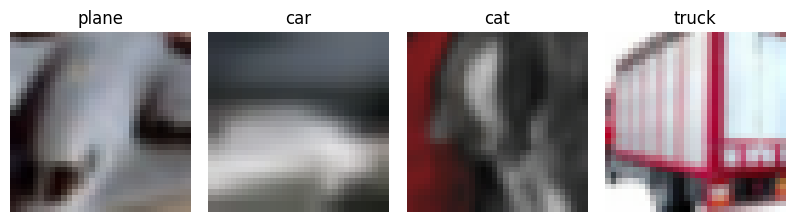

In [40]:
num_images_to_show = 4
fig, axs = plt.subplots(1, num_images_to_show, figsize=(10,10))
np.vectorize(lambda ax:ax.axis('off'))(axs)

for j in range(num_images_to_show):
    axs[j].imshow(imshow(images[j]))
    axs[j].set_title(classes[labels[j].item()])

plt.subplots_adjust(wspace=0.1, hspace = 0)

#### Part 2: Defining the ViT

Create an instance of your model and run it with a random tensor to ensure there is no error. Also check that the output shape is (N, 10) where N is your batch size. **Note**: If you are using a GPU, make sure to move both your model AND input tensor to the GPU device

In [41]:
model = ViT_first(image_size = 128,
            patch_size = 8,
            num_classes = 2,
            dim = 512,
            num_layers = 6,
            heads = 8,
            dropout = 0.1).to(device)

random_input = torch.randn(1,3,128,128).to(device)
print(model(random_input).shape)

torch.Size([1, 512])


Refer to the [torch.optim](https://pytorch.org/docs/stable/optim.html) library. Define the optimizer and learning rate. Use SGD with momentum, with an initial learning rate of 0.01

In [42]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Define the learning rate scheduler (use [cosine annealing](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html#torch.optim.lr_scheduler.CosineAnnealingLR)) and plot the learning rate variation for 100 epochs.

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Text(0, 0.5, 'learning rate')

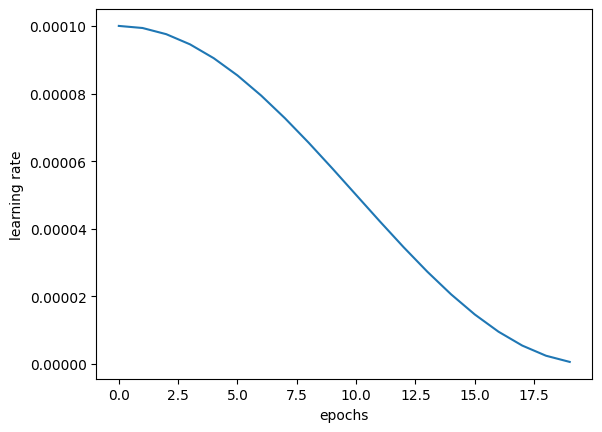

In [43]:
epochs = 20
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

lrs = []
for _ in range(epochs):
    lrs.append(scheduler.get_last_lr())
    scheduler.step()

plt.plot(lrs)
plt.xlabel('epochs')
plt.ylabel('learning rate')

now define the loss funtion. We will use the [cross-entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) loss (also see the input shapes that this loss expects to know how to call it later). Note that this loss applied Softmax on the class logits, and therefore you do not need to define the softmax. This loss is equivalent to applying [LogSoftmax](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html#torch.nn.LogSoftmax) on an input, followed by [NLLLoss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss).

In [44]:
epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
triplet_miner = miners.TripletMarginMiner(type_of_triplets="hard")
criterion = losses.TripletMarginLoss(margin=0.2)

Write the training loop funtion for one iteration.

- Set the model to training mode (since we use dropout which has a different behaviour in training and testing)
- Iterarate through your data loader. Zero-out accumulated gradients in the computation graph, run the inputs to your model and get the outputs, calculate the loss, backpropogate the loss to calculate gradients, and then update the weights
- Your training funtion should return the averaged loss and accuracy at the epoch

In [45]:
print_every = 200
def train(epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        hard_triplets = triplet_miner(outputs, targets)
        loss = criterion(outputs, targets, hard_triplets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        # total += targets.size(0)
        # correct += predicted.eq(targets).sum().item()

        epoch_loss = train_loss/(batch_idx+1)
        # epoch_acc = 100.*correct/total

        if batch_idx % print_every == 0:
            print('Epoch {}/{}, Iter {}/{}, Train Loss: {:.3f}'.format(epoch, epochs, batch_idx, len(trainloader),
                                                                                   epoch_loss))
    return epoch_loss

Write the testing funtion to get the test accuracy and test loss (minimal modifications to the training funtion)

In [46]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(testloader)):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    acc = 100.*correct/total
    loss = test_loss/(batch_idx+1)
    print('Test Accuracy: {:.3f}, Test Loss: {:.3f}'.format(acc, loss))
    return acc

Loop over all the epochs:

- Run the training funtion
- Save the losses and accuracies returned at each epoch
- Run the test funtion
- Save the model/Overwrite the previously saved one if the accuracy improved from the last epoch. Refer [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

For reference, this model should achieve a **test accuracy** of around **59%** after training for 20 epochs.

In [47]:
best_acc = 0

losses = []
accuracies = []

for epoch in range(epochs):
    epoch_loss = train(epoch)
    losses.append(epoch_loss)
    scheduler.step()
    acc = test()
    state = {'model': model.state_dict(),
             'acc': acc,
             'epoch': epoch}
    if acc > best_acc:
        torch.save(state, 'model.pth')
        best_acc = acc

RuntimeError: ignored

Text(0, 0.5, 'train loss')

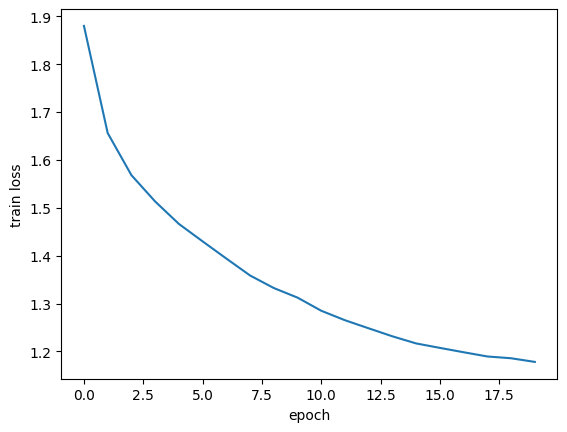

In [ ]:
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('train loss')

Text(0, 0.5, 'train accuracy')

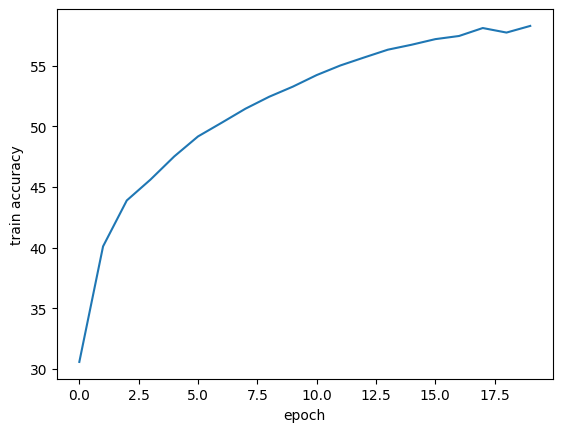

In [ ]:
plt.plot(accuracies)
plt.xlabel('epoch')
plt.ylabel('train accuracy')

### Let's visualize some predictions!

In [ ]:
model.eval()
test_images, gt_labels = next(iter(testloader))

In [ ]:
index_test_image = 1
input_test_img = test_images[index_test_image].unsqueeze(0).to(device)
outputs = model(input_test_img)
_, predicted = outputs.max(1)

(-0.5, 31.5, 31.5, -0.5)

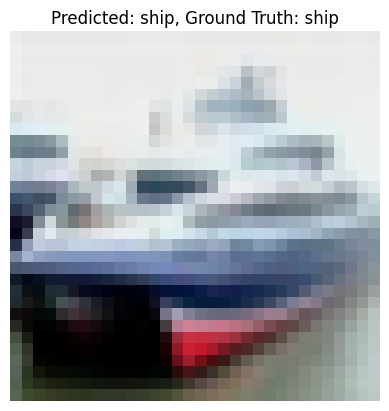

In [ ]:
plt.imshow(imshow(test_images[index_test_image]))
plt.title('Predicted: {}, Ground Truth: {}'.format(classes[predicted.item()],classes[gt_labels[index_test_image].item()]))
plt.axis('off')